In [3]:

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelopeㅊ

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM



from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM,Dropout,Dense
from keras.models import Sequential
import time 
from keras.models import model_from_json
import sys

In [129]:

# 유클리디안 거리 함수 
def getDistanceByPoint(data, model):
    distance = pd.DataFrame([],columns=['Original_vs_Center_Distance'])
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])                     
        Xb = model.cluster_centers_[model.labels_[i]-1]  # 실제 좌표와 학습된 군집 모델이 14개있을때  i번째 데이터의 레이블에 해당하는 군집 중심좌표
        distance.loc[i]= np.linalg.norm(Xa-Xb)          
         
    distance = distance.iloc[:,-1]
    return distance

# Data

## Extract Data

############## Data ##############

각 일자별 화씨 온도에 대한 데이터 셋


In [4]:
df = pd.read_csv("C:/Users/82105/Desktop/data/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv")

In [5]:
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


## Understand Data

In [131]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [132]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [133]:
# check the temperature mean
print(df['value'].mean())

71.2424327082882


<AxesSubplot:xlabel='timestamp'>

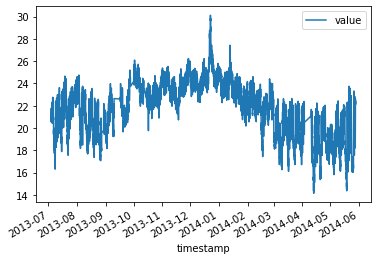

In [134]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# 화씨 온도를 섭씨 온도로 변환
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

## Feature Engineering

In [135]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [136]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [137]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

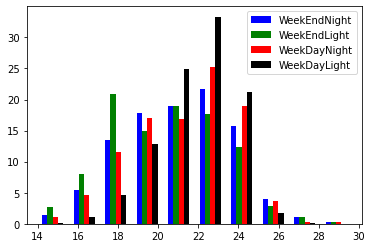

In [138]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
# 카테고리 생성 
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

# Model

## K-Means

- 군집을 형성한 뒤 개별 군집의 Center에서 멀리 떨어진 Point는 Anomaly로 간주 

In [139]:
# Useful한 Feature를 뽑아 StandardScaler 적용
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

# Scaler
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

# Scaler가 적용된 Dataset
data = pd.DataFrame(np_scaled)

# 2개의 Feature로 압축
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# 압축된 2개의 Feature Scaler
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

# 2개의 차원으로 압축된 Scaler가 적용된 DataFrame
data = pd.DataFrame(np_scaled)

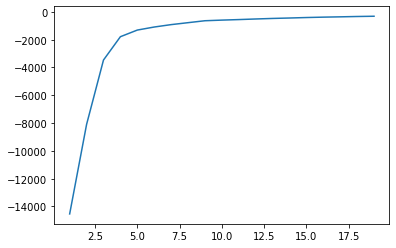

In [140]:
# 1부터 20개까지의 Centroid 설정
n_cluster = range(1, 20)

# cluster의 개수가 1부터 19까지의 Kmeans
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]


# Score = 군집수에 따라 군집내 총 제곱합 (WSS : Within cluster Sum of Squares)의 음수 값
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [141]:
#   X축에 따라 Y축의 감소율이 크게 작아지는 4를  Elbow로 선택 

scores

[-14533.99999999999,
 -8099.039142516138,
 -3465.371921372513,
 -1787.327503885385,
 -1309.5265358514798,
 -1090.4993600263322,
 -917.8381079054545,
 -777.8340082840557,
 -638.6781560574028,
 -593.5971703496692,
 -555.0228074318842,
 -512.3694985336748,
 -473.1726659890434,
 -442.40597178312555,
 -407.8592723368034,
 -380.0569566762312,
 -358.02165445632465,
 -333.3449578228972,
 -315.2239895858374]

In [142]:
df['cluster'] = kmeans[4].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    1876
3    1845
1    1522
2    1428
4     596
Name: cluster, dtype: int64

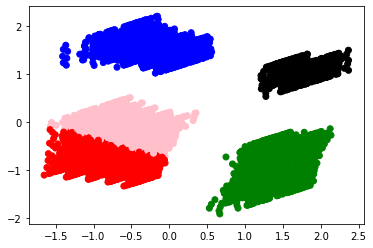

In [143]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [144]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[4])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min() # nlargest  = 값이 높은 n번째 까지 출력중에 가장 작은 값 
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int) # 정상이면 0 이상이면1 

In [145]:
threshold

3.6535514148675694

In [146]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,principal_feature1,principal_feature2,anomaly21
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2,1,0.066191,1.755363,0
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,1,-0.009413,1.647609,0
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,1,-0.009359,1.577677,0
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,1,0.061592,1.543184,0
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,1,0.031660,1.458262,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3,3,-0.663130,-0.218870,0
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3,3,-0.669607,-0.292067,0
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3,3,-0.679271,-0.366858,0
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3,3,-0.684664,-0.439514,0


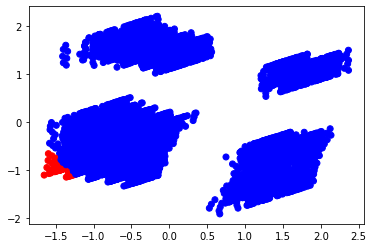

In [147]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

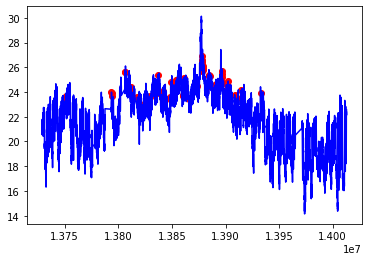

In [148]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

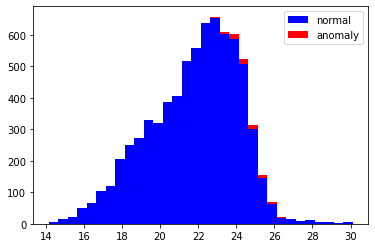

In [149]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Categories + Gaussian


-> 각 카테고리 레이블들을 가우시안 분포에 맵핑하여 특정 Threshold를 넘으면 Anomaly로 탐지

In [150]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

In [151]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,principal_feature1,principal_feature2,anomaly21
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2,1,0.066191,1.755363,0
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,1,-0.009413,1.647609,0
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,1,-0.009359,1.577677,0
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,1,0.061592,1.543184,0
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,1,0.031660,1.458262,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3,3,-0.663130,-0.218870,0
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3,3,-0.669607,-0.292067,0
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3,3,-0.679271,-0.366858,0
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3,3,-0.684664,-0.439514,0


<AxesSubplot:>

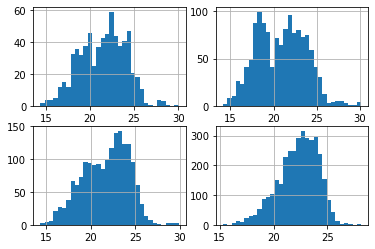

In [152]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [153]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

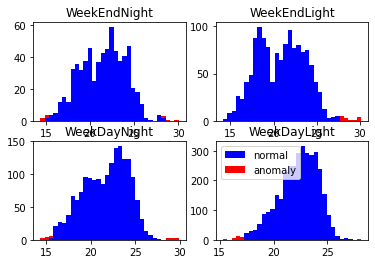

In [154]:

a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [155]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

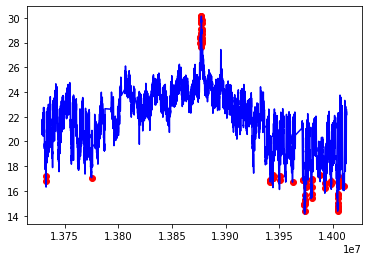

In [156]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

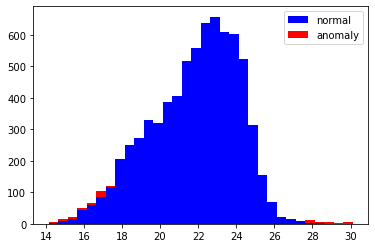

In [157]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Isolation Forest

In [158]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly23'] = pd.Series(model.predict(data))
df['anomaly23'] = df['anomaly23'].map( {1: 0, -1: 1} )
print(df['anomaly23'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


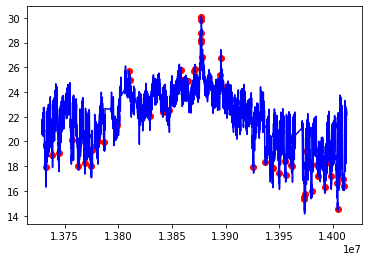

In [159]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly23'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

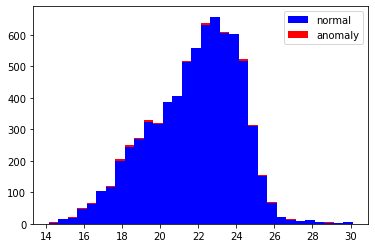

In [160]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly23'] == 0, 'value']
b = df.loc[df['anomaly23'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## One Class SVM

In [161]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly24'] = pd.Series(model.predict(data))
df['anomaly24'] = df['anomaly24'].map( {1: 0, -1: 1} )
print(df['anomaly24'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


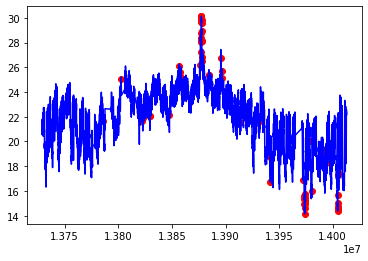

In [162]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

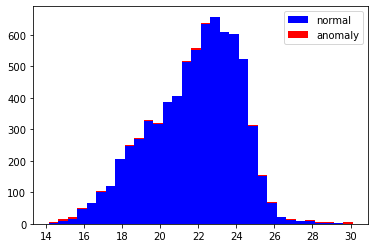

In [163]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## RNN

In [169]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [172]:
len(df)

7267

In [173]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [ ]:
# Train the model
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)

In [187]:
# Build the model
model = Sequential()

model.add(LSTM(
    units = 50 , input_dim=x_train.shape[-1],
    #input_dim=x_train.shape[-1],
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.0076482295989990234


In [190]:
# Train the model
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=30,
    validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 5s 2s/step - loss: 0.7141 - val_loss: 0.8671
Epoch 2/30
2/2 [==============================] - 2s 860ms/step - loss: 0.2579 - val_loss: 0.6624
Epoch 3/30
2/2 [==============================] - 2s 1s/step - loss: 0.2211 - val_loss: 0.3394
Epoch 4/30
2/2 [==============================] - 2s 908ms/step - loss: 0.1110 - val_loss: 0.2418
Epoch 5/30
2/2 [==============================] - 2s 900ms/step - loss: 0.1083 - val_loss: 0.2106
Epoch 6/30
2/2 [==============================] - 2s 916ms/step - loss: 0.1249 - val_loss: 0.2136
Epoch 7/30
2/2 [==============================] - 2s 922ms/step - loss: 0.0970 - val_loss: 0.1922
Epoch 8/30
2/2 [==============================] - 2s 958ms/step - loss: 0.0917 - val_loss: 0.1915
Epoch 9/30
2/2 [==============================] - 2s 898ms/step - loss: 0.0887 - val_loss: 0.1828
Epoch 10/30
2/2 [==============================] - 2s 873ms/step - loss: 0.0872 - val_loss: 0.1815
Epoch 11/30
2/2 [========

In [191]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)

for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

32/32 [==============================] - 1s 9ms/step


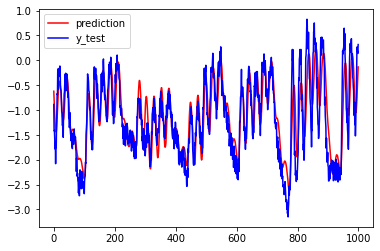

In [192]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [193]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly25'] = complement.append(test, ignore_index='True')
print(df['anomaly25'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


<ipython-input-193-4837cb7ad316>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df['anomaly27'] = complement.append(test, ignore_index='True')


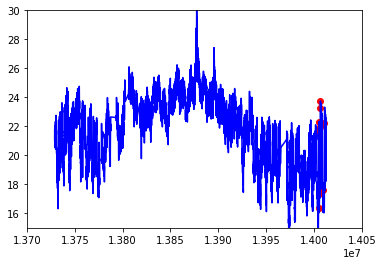

In [194]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

No handles with labels found to put in legend.


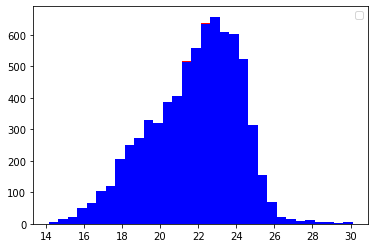

In [195]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

# 결과

-> 대체적으로 5개의 모델 모두 온도가 상대적으로 가장 높거나 낮은 한 여름, 한 겨울을 이상치로 탐지하는 것을 확인할 수 있다.